In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from aparent.losses.aparent_losses import *

from visualization.seqprop_visualization import *
from generator.seqprop_generator import *
from predictor.seqprop_predictor import *
from predictor.definitions.aparent_legacy_without_padding_with_dense import load_saved_predictor
from optimizer.seqprop_optimizer import *


Using TensorFlow backend.


In [5]:

#Define target isoform loss function
def get_isoform_loss(target_isoform_use, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, isoform_start=80, isoform_end=115, punish_up_c=0.0, punish_up_g=0.0, punish_dn_g=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_iso = np.zeros((1, 1, 1))
    target_iso[:, :, 0] = target_isoform_use
    
    #target_entropy_mse = get_target_entropy_mse(pwm_start=entropy_start, pwm_end=entropy_end, target_bits=target_bits)
    #target_entropy_mse = get_target_entropy_mae(pwm_start=entropy_start, pwm_end=entropy_end, target_bits=target_bits)
    
    #target_entropy_mse = get_target_entropy_sme(pwm_start=entropy_start, pwm_end=entropy_end, target_bits=target_bits)
    
    #cse_entropy_mse = get_target_entropy_sme(pwm_start=49, pwm_end=55, target_bits=1.95)
    
    #use_entropy_mse = get_target_entropy_sme(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    #cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    #dse_entropy_mse = get_target_entropy_sme(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    use_entropy_mse = get_margin_entropy(pwm_start=use_start, pwm_end=use_end, min_bits=use_target_bits)
    cse_entropy_mse = get_margin_entropy(pwm_start=cse_start, pwm_end=cse_end, min_bits=cse_target_bits)
    dse_entropy_mse = get_margin_entropy(pwm_start=dse_start, pwm_end=dse_end, min_bits=dse_target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=0, pwm_end=49)
    
    punish_up_g_func = get_punish_g(pwm_start=0, pwm_end=49)
    punish_dn_g_func = get_punish_g(pwm_start=55, pwm_end=100)
    
    punish_up_aa_func = get_punish_aa(pwm_start=0, pwm_end=49)
    punish_dn_aa_func = get_punish_aa(pwm_start=55, pwm_end=100)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred, dense_out = predictor_outputs
        
        #Create target cut constant
        iso_true = K.tile(K.constant(target_iso), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        #iso_loss = 1.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        iso_loss = 1.0 * K.mean(sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        seq_loss += punish_up_g * K.mean(punish_up_g_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_g * K.mean(punish_dn_g_func(sampled_pwm), axis=0)
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        #entropy_loss = entropy_weight * target_entropy_mse(pwm) + 0.5 * cse_entropy_mse(pwm)
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, library_context, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=185, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)#True
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.5)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=49, isoform_start=60, isoform_end=95, dedicated_isoform_pred=True, pwm_start=49-40, pwm_end=55+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts



In [6]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models/legacy_models')
model_name = 'aparent_theano_legacy_30_31_34.h5'
model_path = os.path.join(save_dir, model_name)

Running optimization experiment 'Alien2 Isoforms'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 63s 31ms/step - loss: 0.3052


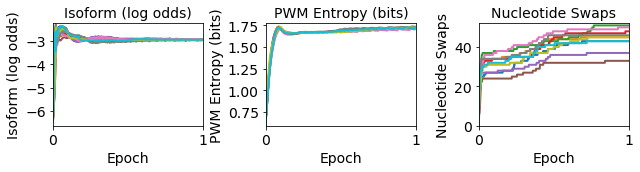

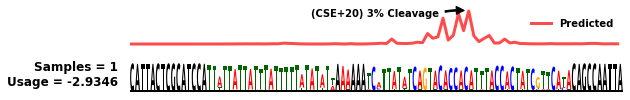

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 70s 35ms/step - loss: 0.5008


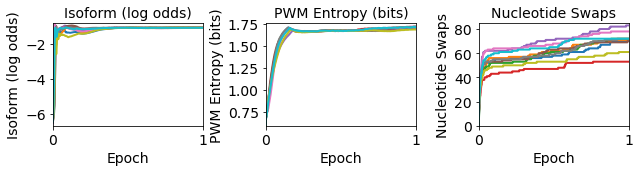

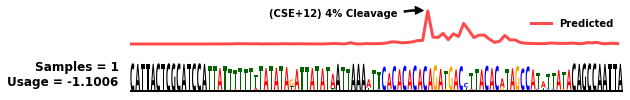

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 68s 34ms/step - loss: 0.7330


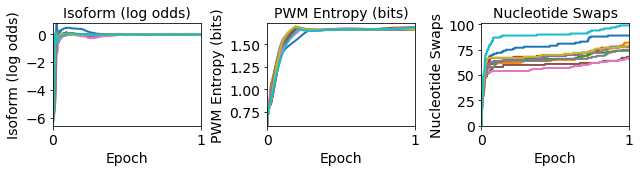

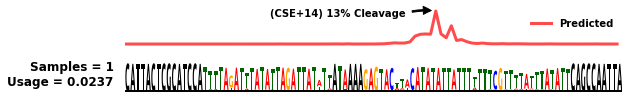

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 69s 34ms/step - loss: 0.9385


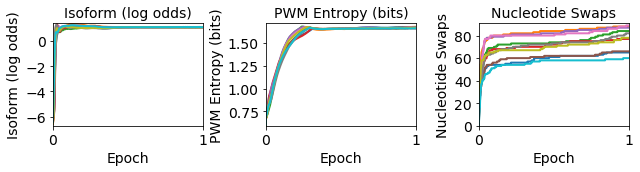

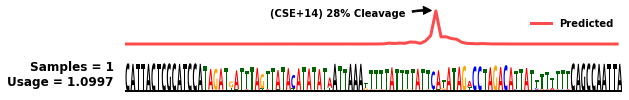

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 65s 33ms/step - loss: 1.3346


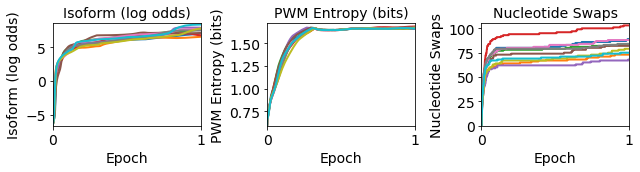

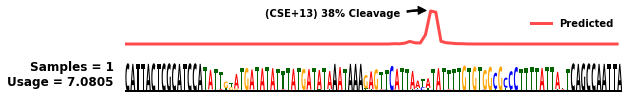

In [7]:
#Optimize target isoform proportions for the 'Alien2' (aka 'Doubledope') library

seq_template = 'XXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTACG'
library_context = 20

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Alien2 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=24,
        use_end=49,
        use_target_bits=1.5,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=95,
        dse_target_bits=1.5,
        entropy_weight=0.1,
        punish_up_c=0.001,
        punish_up_g=0.001,
        punish_dn_g=0.0001,
        punish_up_aa=0.0025,
        punish_dn_aa=0.001,
    )
    for target_iso in iso_objectives
]

alien2_pwms, alien2_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



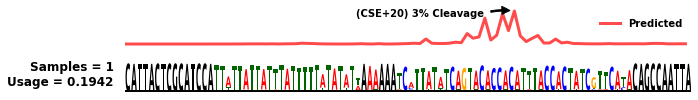

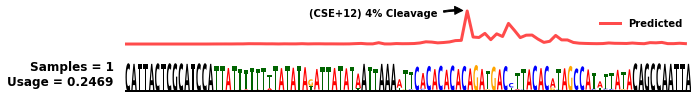

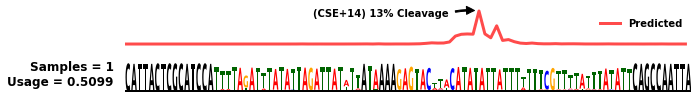

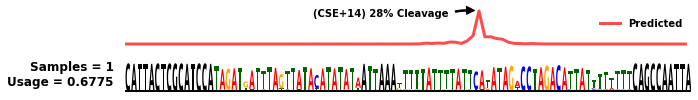

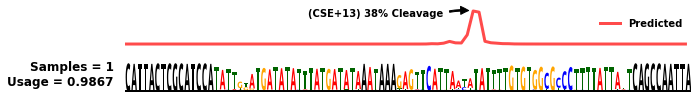

In [11]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien2_pwms
cuts = alien2_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 60:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, cse_start_pos=49, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=49-40, plot_end=55+50)


Running optimization experiment 'TOMM5 Isoforms'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 69s 34ms/step - loss: 0.2832


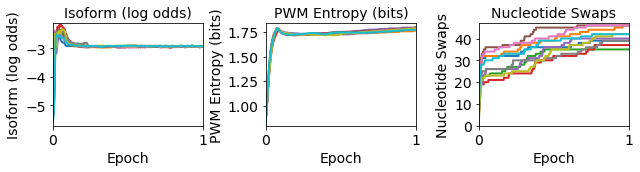

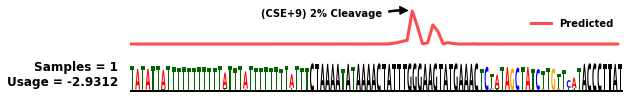

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 62s 31ms/step - loss: 0.4503


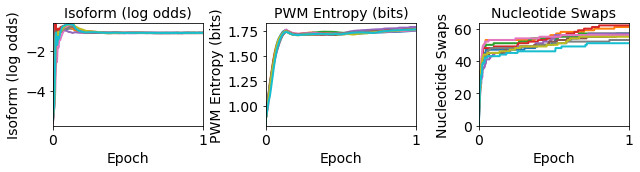

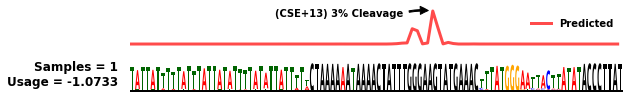

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 62s 31ms/step - loss: 0.7037


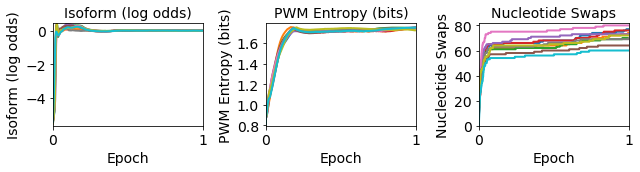

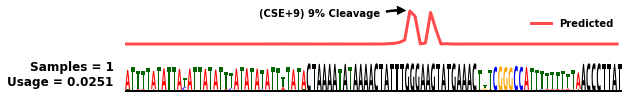

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 61s 31ms/step - loss: 0.9243


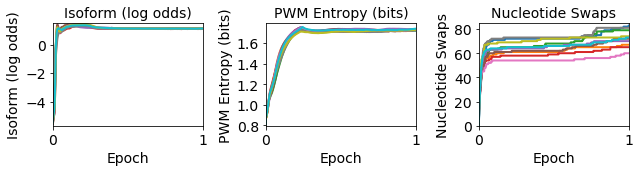

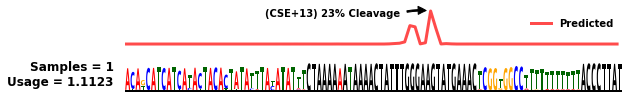

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 71s 35ms/step - loss: 1.2824


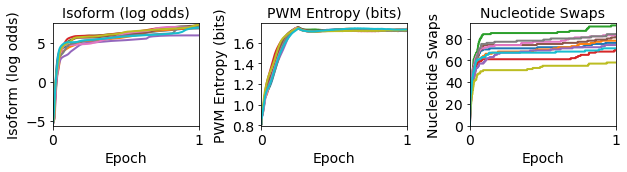

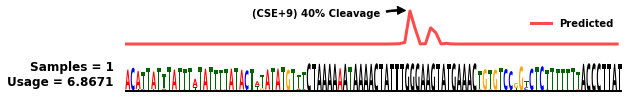

In [12]:
#Optimize target isoform proportions for the 'TOMM5' library

seq_template = 'TGCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAAAANANAAAACTATTTGGGAAGTATGAAACNNNNNNNNNNNNNNNNNNNNACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA'
library_context = 11

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'TOMM5 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=4,
        use_end=44,
        use_target_bits=1.5,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=77,
        dse_end=97,
        dse_target_bits=1.5,
        entropy_weight=0.1,
        punish_up_c=0.001,
        punish_up_g=0.001,
        punish_dn_g=0.0001,
        punish_up_aa=0.0025,
        punish_dn_aa=0.001,
    )
    for target_iso in iso_objectives
]

tomm5_pwms, tomm5_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



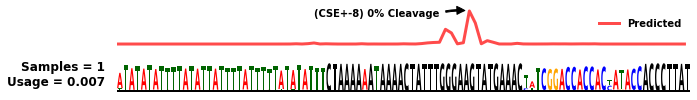

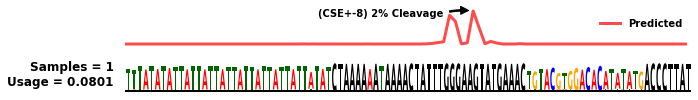

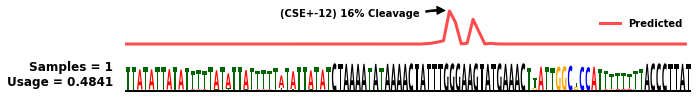

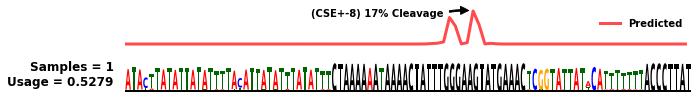

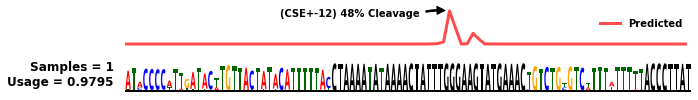

In [13]:
#Plot one PWM sequence logo per optimized objective (Experiment 'TOMM5 Isoforms')

pwms = tomm5_pwms
cuts = tomm5_cuts

pwm_index = 4 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 60:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=49-40, plot_end=55+50)


Running optimization experiment 'Max Isoforms of 8 libraries'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 59s 30ms/step - loss: 1.3598


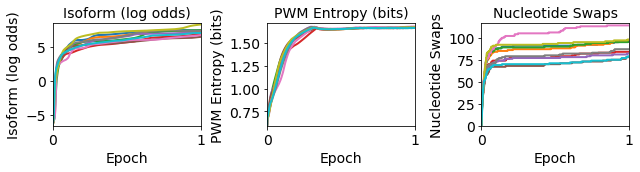

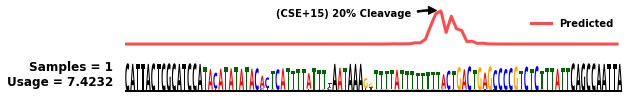

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 62s 31ms/step - loss: 1.3291


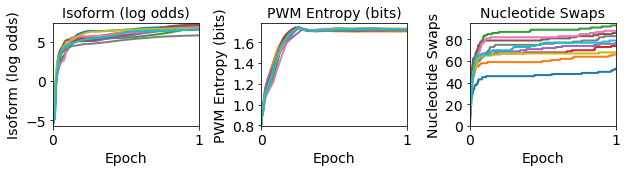

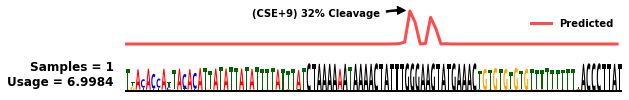

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 70s 35ms/step - loss: 0.3384


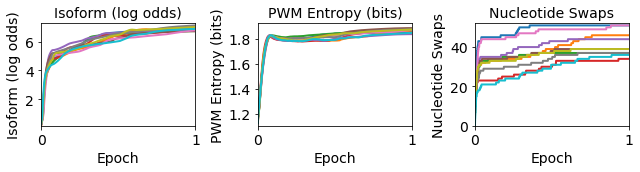

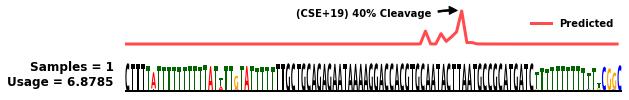

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 130s 65ms/step - loss: 0.9078


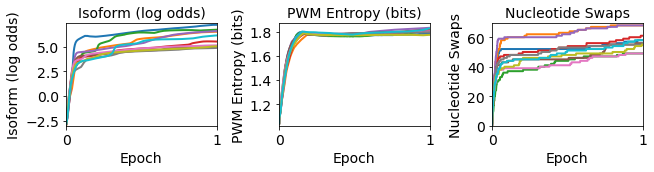

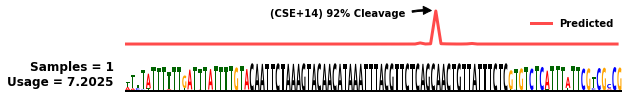

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 145s 72ms/step - loss: 0.2633


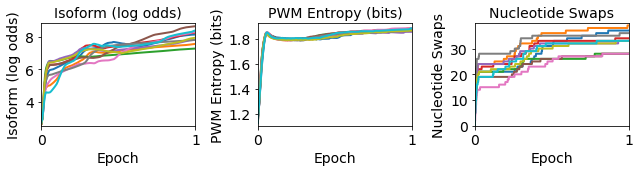

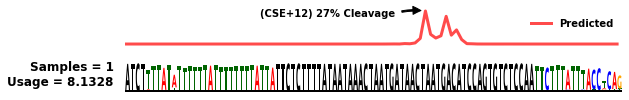

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 145s 73ms/step - loss: 0.3310


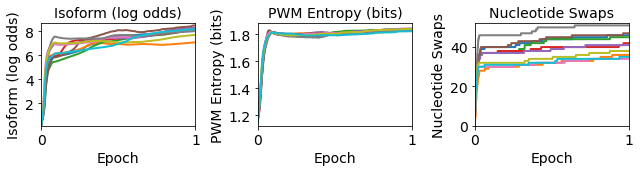

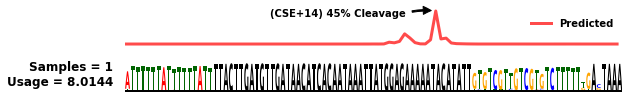

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 142s 71ms/step - loss: 1.1998


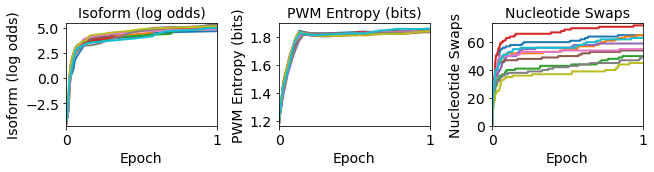

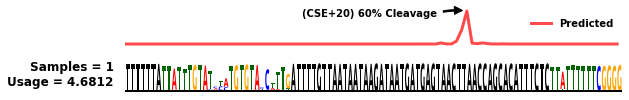

Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 147s 73ms/step - loss: 0.2346


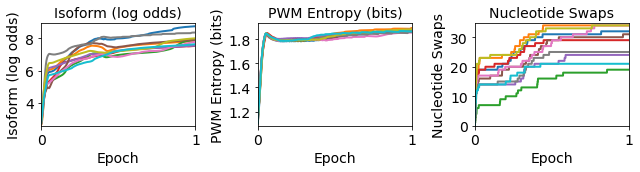

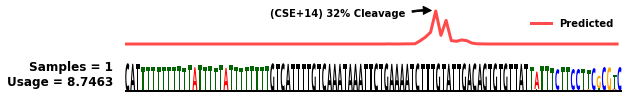

In [14]:
#Maximize isoform proportions for 8 minigene libraries

seq_templates = [
    'XXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTACG',
    'TGCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAAAANANAAAACTATTTGGGAAGTATGAAACNNNNNNNNNNNNNNNNNNNNACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGGA',
    'ATCTCTGAGCTTTNNNNNNNNNNNNNNNNNNNNNNNNNTTGCTGCAGAGAATAAAAGGACCACGTGCAATACTTAATGCCGCATGATCNNNNNNNNNNNNNNNNNNNNNNNNNGGCTCTTTTGACAGCCTTTGGCGTCTGTAGAATAAATGCTGTGGCTCCTGCTGGCTGCTGTGGTGTTCACCX',
    'TGCATTTGNNNNNNNNNNNNNNNNNNNNNNNNNCAATTCTAAAGTACAACATAAATTTACGTTCTCAGCAACTGTTATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNAATATACATTCAGTTATTAAGAAATAAACTGCTTTCTTAATACATACTGTGCATTATAATTGGAGAAATAGAATATX',
    'TCTTCTGAAATCTNNNNNNNNNNNNNNNNNNNNNNNNNTTCTCTTTTATAATAAACTAATGATAACTAATGACATCCAGTGTCTCCAANNNNNNNNNNNNNNNNNNNNNNNNNCACTTCCAAATAAAAATATGTAAATGAGTGGTTAATCTTTAGTTATTTTAAGATGATTTTAGGGTTTTGCTX',
    'ANNNNNNNNNNNNNNNNNNNNNNNNNTTACTTGATGTTGATAACATCACAATAAATTATGGAGAAAAATACATATTNNNNNNNNNNNNNNNNNNNNNNNANTAAAGTGTTTTCTTTTAAATCAACTCTAAATAGCTCCATTCTCATAGTCACTAGTCAGACCGCTCGCGCACTACTCAGCGACCX',
    'CGATCTTCTTTTTTTANNNNNNNNNNNNNNNNNNNNNNNNNATTTTGTTAATAATAAGATAATGATGAGTAACTTAACCAGCACATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNGTTTTCTGATGACATAATAAAGACAGATCATTTCAGAATCTGGCCCTTGTGCAGGGGAGGAGGGAGGCX',
    'CTTGAATTTCATNNNNNNNNNNNNNNNNNNNNNNNNNGTCATTTTGTCAAATAAATTCTGAAAATCTTTGTATTGACAGTGTGTTATNNNNNNNNNNNNNNNNNNNNNNNNNAGTGCTCAATAAAAAGAATAAAGAGGAAACAGCACTGGATCTATACCTATACAAAACAAGCTACCAGCGCTCX'
]

region_start_ends = [
    [[24, 49], [49, 55], [55, 95]],
    [[4, 44], [49, 55], [77, 97]],
    [[13, 13 + 25], [49, 55], [13 + 75, 13 + 100]],
    [[8, 8 + 25], [49, 55], [8 + 75, 8 + 100]],
    [[13, 13 + 25], [49, 55], [13 + 75, 13 + 100]],
    [[1, 1 + 25], [49, 55], [1 + 75, 1 + 100]],
    [[16, 16 + 25], [49, 55], [16 + 75, 16 + 100]],
    [[12, 12 + 25], [49, 55], [12 + 75, 12 + 100]]
]

libraries = [
    'Alien2',
    'TOMM5',
    'AARS',
    'ATR',
    'HSPE1',
    'SNHG6',
    'SOX13',
    'WHAMMP2'
]

library_contexts = [
    20,
    11,
    30,
    31,
    32,
    33,
    34,
    35
]

iso_objectives = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Max Isoforms of 8 libraries'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        use_start=region[0][0],
        use_end=region[0][1],
        use_target_bits=1.5,
        cse_start=region[1][0],
        cse_end=region[1][1],
        cse_target_bits=1.9,
        dse_start=region[2][0],
        dse_end=region[2][1],
        dse_target_bits=1.5,
        entropy_weight=0.1,
        punish_up_c=0.001,
        punish_up_g=0.001,
        punish_dn_g=0.0001,
        punish_up_aa=0.0025,
        punish_dn_aa=0.001,
    )
    for target_iso, region in zip(iso_objectives, region_start_ends)
]

max_pwms = []
max_cuts = []

for seq_template, library_context, loss in zip(seq_templates, library_contexts, losses) :

    pwm, cut = run_seqprop([seq_template], [loss], library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)

    max_pwms.extend(pwm)
    max_cuts.extend(cut)


Library = Alien2


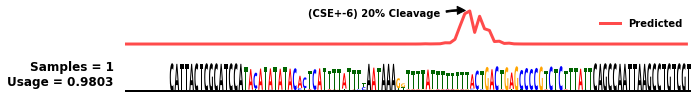

Library = TOMM5


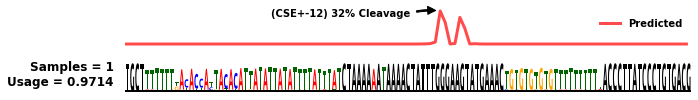

Library = AARS


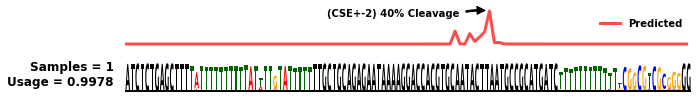

Library = ATR


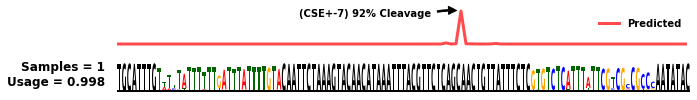

Library = HSPE1


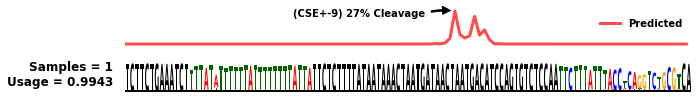

Library = SNHG6


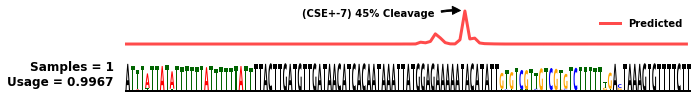

Library = SOX13


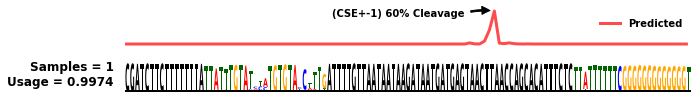

Library = WHAMMP2


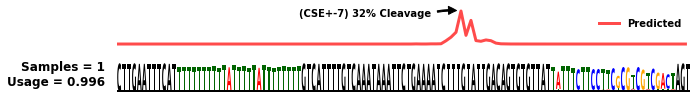

In [15]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Max Isoforms of 6 libraries')

pwms = max_pwms
cuts = max_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, library in enumerate(libraries) :
    
    print("Library = " + str(library))
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 60:95], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=seq_templates[obj_index], figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=0, plot_end=115)
